## Code to move heightmaps to single folder for easier testing. Also storing ids for future backtracking

In [1]:
import fnmatch
import scipy.io as sio
import os
import numpy as np
import pandas as pd

from shutil import copyfile
from random import shuffle

import matplotlib.pyplot as plt

from PIL import Image

from collections import Counter


In [2]:
dest_path = "data\\sorted\\agg"
id_file_name = 'ids.csv'
id_file_name2 = 'ids2.csv'

source_folders = []

source_folders.append(("data\\original\\2017.11.09\\1800", "2017.11.09", 1800))
source_folders.append(("data\\original\\2017.11.09\\3600", "2017.11.09", 3600))
source_folders.append(("data\\original\\2017.11.17\\1\\data", "2017.11.17", 1800))
source_folders.append(("data\\original\\2017.11.17\\2\\data", "2017.11.17", 3600))
source_folders.append(("data\\original\\2017.11.17\\5\\data", "2017.11.17", 7200))
source_folders.append(("data\\original\\2017.11.22\\1\\data", "2017.11.22", 1800))
source_folders.append(("data\\original\\2017.11.22\\2\\data", "2017.11.22", 3600))
source_folders.append(("data\\original\\2017.11.22\\3\\data", "2017.11.22", 7200))
source_folders.append(("data\\original\\2017.11.23\\1\\data", "2017.11.23", 1800))
source_folders.append(("data\\original\\2017.11.23\\2\\data", "2017.11.23", 3600))
source_folders.append(("data\\original\\2017.11.23\\3\\data", "2017.11.23", 7200))

In [151]:
write_files = True

Load previous database of ids if available

In [152]:
df = None

for file in os.listdir(dest_path):
    if fnmatch.fnmatch(file, id_file_name):
        df = pd.read_csv(f'{dest_path}\\{file}')

if df is None:
    df = pd.DataFrame(columns=['name', 'date', 'flow_rate', 'source'])

In [153]:
print(df.shape)

(0, 4)


In [154]:
files = []

count = df.shape[0]

for source_path, date, flow in source_folders:
    for file in os.listdir(source_path):
        if fnmatch.fnmatch(file, '*.mat'):
            files.append([str(count), date, flow, file])
            if write_files:
                copyfile(f'{source_path}\\{file}', f'{dest_path}\\{count}.mat')
            count += 1
        
df2 = pd.DataFrame(files, columns=['name', 'date', 'flow_rate', 'source'])
df = df.append(df2, ignore_index=True)

In [155]:
df.to_csv(os.path.join(dest_path, id_file_name))

## Find max image size

In [157]:
files = []

max_x = 0
max_y = 0

filenames = []
images = []

for file in os.listdir(dest_path):
    if fnmatch.fnmatch(file, '*.mat'):
        files.append(file)
        
        hm = sio.loadmat(f'{dest_path}\\{file}')['height_r']
        images.append((hm, file))
        filenames.append(file)
        
        max_x=max(hm.shape[0],max_x)
        max_y=max(hm.shape[1],max_y)
                
print(max_x)
print(max_y)
print(len(images))

991
507
201


## Pad all images to max size

In [158]:
padded_images = []

for m, filename in images:
    filename = filename[:-4]
    padded_images.append((np.pad(np.copy(m), ((0,max_x-m.shape[0]),(0,max_y-m.shape[1])), 'constant', constant_values=(0)), filename))

## Save Padded images as numpy array

In [159]:
for image, filename in padded_images:
    if write_files:
        np.save(f'{dest_path}\\{filename}', np.array(image))


## Data Augmentation

### Flip images along x-axis 

In [160]:
all_imgs = padded_images.copy()
files = []

for image, filename in padded_images:
    new_name = filename+"_flipped"
    flipped_img = np.fliplr(image)
    
    old_image = df.loc[df['name'] == filename].copy()
    date = old_image['date'].values[0]
    flow = old_image['flow_rate'].values[0]
    source = old_image['source'].values[0]
        
    if write_files:
        np.save(f'{dest_path}\\{new_name}', flipped_img)
        
    all_imgs.append((flipped_img, new_name))
    
    files.append([new_name, date, flow, source])

df2 = pd.DataFrame(files, columns=['name', 'date', 'flow_rate', 'source'])
df = df.append(df2, ignore_index=True)
    
df.to_csv(os.path.join(dest_path, id_file_name))

In [161]:
print(len(all_imgs))

402


## Split into Training and Test

In [162]:
train_path = dest_path+"\\train\\"
test_path = dest_path+"\\test\\"

In [163]:
df_train = None
df_test = None

for file in os.listdir(train_path):
    if fnmatch.fnmatch(file, id_file_name):
        df_train = pd.read_csv(f'{train_path}\\{file}')

if df_train is None:
    df_train = pd.DataFrame(columns=['name', 'date', 'flow_rate', 'source'])

for file in os.listdir(test_path):
    if fnmatch.fnmatch(file, id_file_name):
        df_test = pd.read_csv(f'{test_path}\\{file}')

if df_test is None:
    df_test = pd.DataFrame(columns=['name', 'date', 'flow_rate', 'source'])


In [164]:
shuffle(all_imgs)

count = 0

for img, filename in all_imgs:
    file_data = df.loc[df['name'] == filename]
    if count < 40:
        df_test = df_test.append(file_data.copy(), ignore_index=True)
        if write_files:
            np.save(f'{dest_path}\\test\\{filename}', img)
    else:
        df_train = df_train.append(file_data, ignore_index=True)
        if write_files:
            np.save(f'{dest_path}\\train\\{filename}', img)
    count += 1

print(df_test)
    
if write_files:
    #df.to_csv(os.path.join(dest_path, id_file_name))
    df_train.to_csv(os.path.join(train_path, id_file_name))
    df_test.to_csv(os.path.join(test_path, id_file_name))


           name        date flow_rate                    source
0            85  2017.11.22      1800  47.59 s.tifheightmap.mat
1           180  2017.11.23      3600  66.20 s.tifheightmap.mat
2           137  2017.11.23      1800  30.40 s.tifheightmap.mat
3           186  2017.11.23      7200  13.40 s.tifheightmap.mat
4    83_flipped  2017.11.22      1800  43.40 s.tifheightmap.mat
5            31  2017.11.17      1800   7.75 s.tifheightmap.mat
6   112_flipped  2017.11.22      7200  15.60 s.tifheightmap.mat
7            76  2017.11.22      1800   0.20 s.tifheightmap.mat
8     3_flipped  2017.11.09      1800     chip2_05heightmap.mat
9            27  2017.11.17      1800  17.25 s.tifheightmap.mat
10          178  2017.11.23      3600  63.41 s.tifheightmap.mat
11  117_flipped  2017.11.22      7200  25.60 s.tifheightmap.mat
12  160_flipped  2017.11.23      3600  13.20 s.tifheightmap.mat
13          179  2017.11.23      3600  65.00 s.tifheightmap.mat
14  171_flipped  2017.11.23      3600  3

## Data Analysis

In [165]:
df['flow_rate'].value_counts()

3600    154
1800    132
7200    116
Name: flow_rate, dtype: int64

In [213]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [np.load(f'{train_path}{filename}.npy') for filename in filenames]
    
    return plot_images(imgs, labels, rows)
    
        
def plot_images(imgs, labels, rows=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(20, 20))

    cols = len(imgs) // rows + 1

    for i in range(min(len(imgs), 1000)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

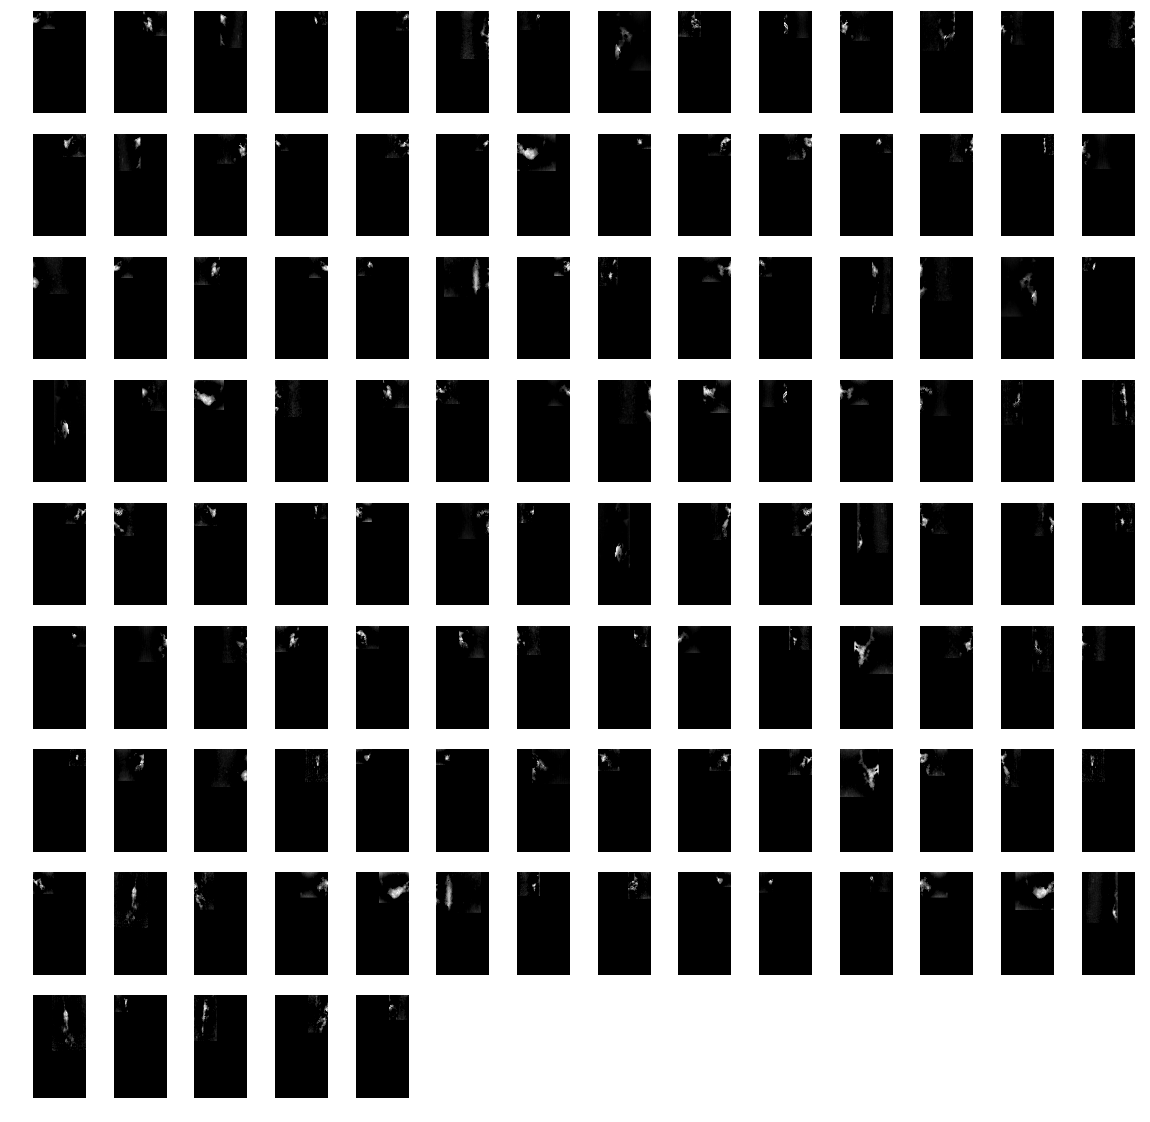

In [214]:
slow = df_train[df_train['flow_rate'] == 1800]
plot_images_for_filenames(list(slow['name']), None, rows=9)

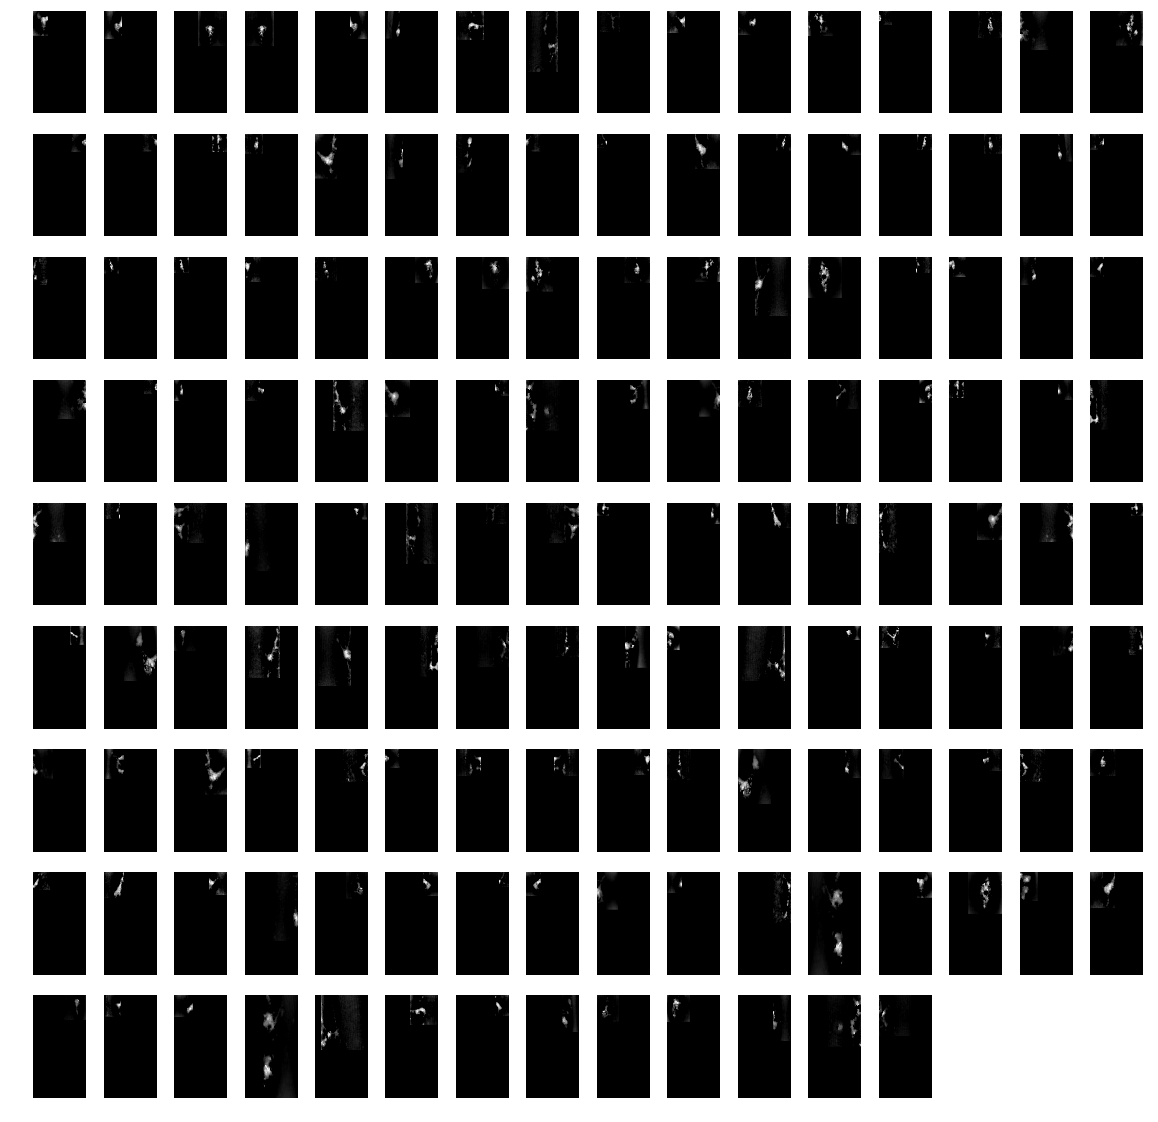

In [215]:
medium = df_train[df_train['flow_rate'] == 3600]
plot_images_for_filenames(list(medium['name']), None, rows=9)

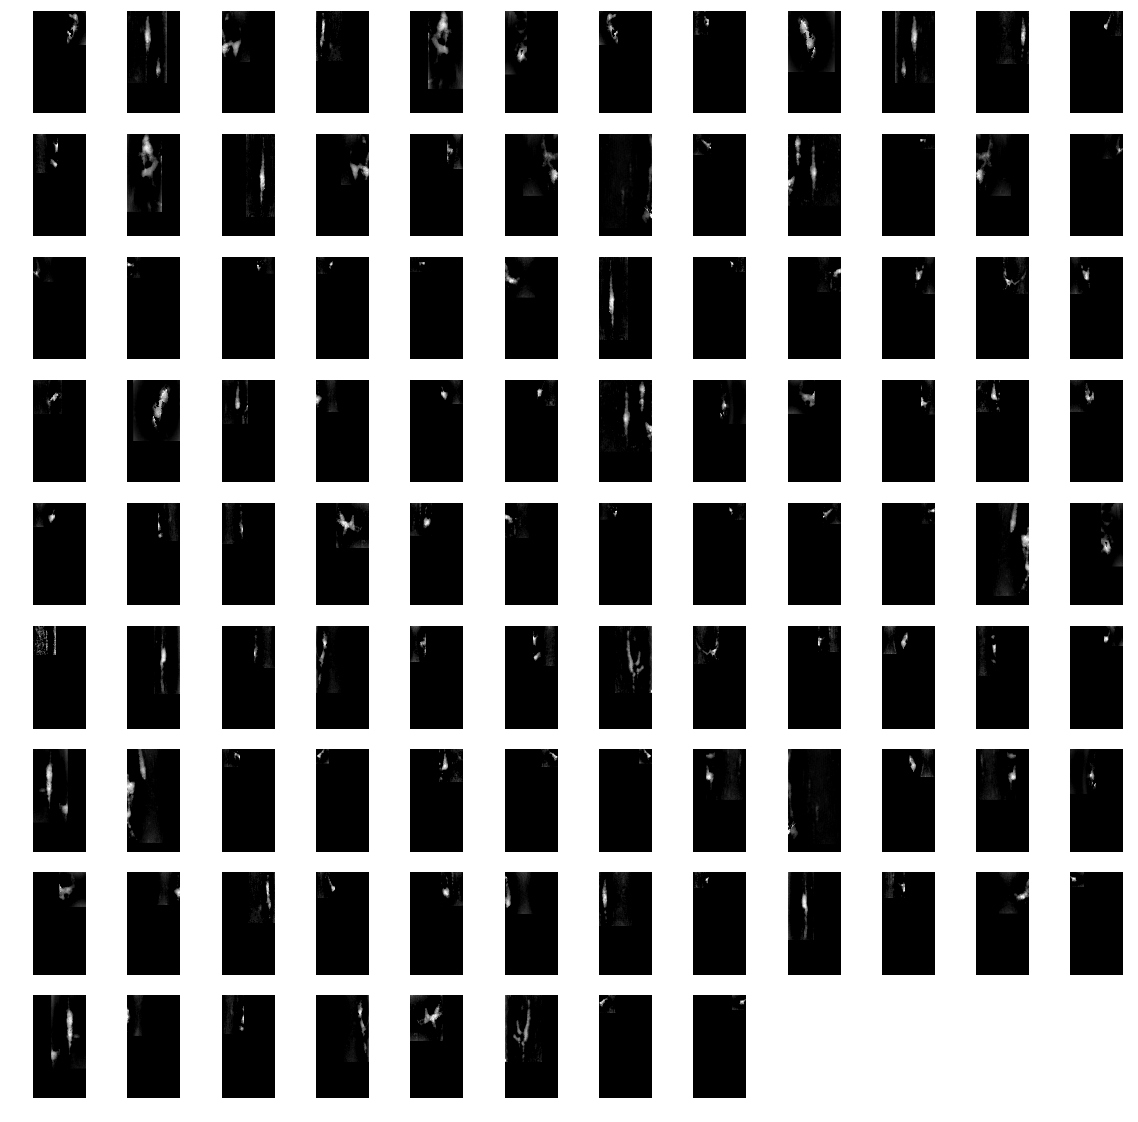

In [216]:
fast = df_train[df_train['flow_rate'] == 7200]
plot_images_for_filenames(list(fast['name']), None, rows=9)

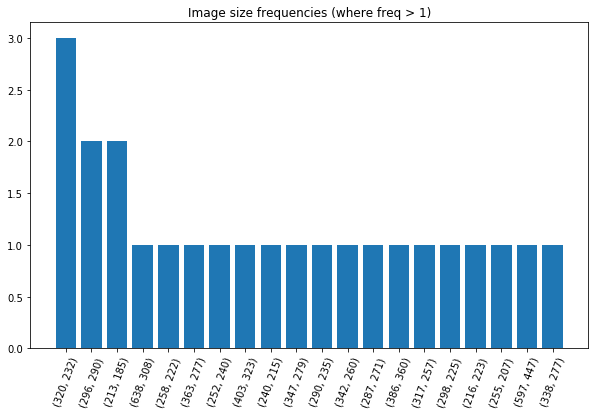

In [6]:
df = []

for file in os.listdir(dest_path):
    if fnmatch.fnmatch(file, '*.mat'):
        hm = sio.loadmat(f'{dest_path}\\{file}')['height_r']
        df.append(hm)
        
img_sizes = Counter([i.shape for i in df])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items()}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")

plt.show()